# Experiments results

Here, we will evaluate the loss of our models for fixed parameters. Then, we will vary the number of recommended the parameters and evaluate the performance of the models in terms of the best metrics obtained during the training process (for the test set).

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# Device setting: CPU or GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Models implementation

Here is the full reimplementation of the MLP model and the Neural Matrix Factorization models in Pytorch.

In [3]:
# Architecture of the MLP model
class MLPModel(nn.Module):
    def __init__(self, num_users, num_items, layers=[64, 32, 16, 8], reg_layers=[0, 0, 0, 0]):
        super(MLPModel, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, layers[0] // 2)
        self.item_embedding = nn.Embedding(num_items, layers[0] // 2)
        
        # Fully connected layers
        layer_sizes = [layers[0]] + layers
        self.fc_layers = nn.ModuleList()
        
        for i in range(1, len(layer_sizes)):
            self.fc_layers.append(
                nn.Linear(layer_sizes[i-1], layer_sizes[i])
            )
            self.fc_layers.append(nn.ReLU())
        
        # Final prediction layer
        self.prediction = nn.Linear(layers[-1], 1)  
        # The sigmoid function is applied directly in the loss (it is not important here since the sigmoid is an increasing function)

    def forward(self, user_input, item_input):
        user_latent = self.user_embedding(user_input)
        item_latent = self.item_embedding(item_input)
        
        vector = torch.cat([user_latent, item_latent], dim=-1)
        
        for layer in self.fc_layers:
            vector = layer(vector)
        
        prediction = self.prediction(vector)
        
        return prediction
    
    def predict(self, user_input, item_input, batch_size=256):
        self.eval() 
        all_predictions = []

        # Batch prediction
        for i in range(0, len(user_input), batch_size):
            batch_user_input = torch.tensor(user_input[i:i + batch_size], dtype=torch.long).to(device)
            batch_item_input = torch.tensor(item_input[i:i + batch_size], dtype=torch.long).to(device)

            with torch.no_grad():  # To save memory
                batch_preds = self.forward(batch_user_input, batch_item_input)
                all_predictions.append(batch_preds)

        return torch.cat(all_predictions, dim=0)

In [4]:
# Architecture of the NeuMF model
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, mf_dim, layers, reg_layers, reg_mf):
        super(NeuMF, self).__init__()
        
        # Embedding for the Matrix Factorization part
        self.mf_user_embedding = nn.Embedding(num_users, mf_dim)
        self.mf_item_embedding = nn.Embedding(num_items, mf_dim)
        
        # Embedding for the MLP part
        self.mlp_user_embedding = nn.Embedding(num_users, layers[0] // 2)
        self.mlp_item_embedding = nn.Embedding(num_items, layers[0] // 2)
        
        # MLP layers
        self.mlp_layers = nn.Sequential()
        for i in range(1, len(layers)):
            self.mlp_layers.add_module(f"linear_{i}", nn.Linear(layers[i-1], layers[i]))
            self.mlp_layers.add_module(f"relu_{i}", nn.ReLU())
        
        # Final prediction layer
        predict_size = mf_dim + layers[-1]
        self.final_layer = nn.Linear(predict_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_input, item_input):
        # MF part
        mf_user_latent = self.mf_user_embedding(user_input)
        mf_item_latent = self.mf_item_embedding(item_input)
        mf_vector = mf_user_latent * mf_item_latent  # Element-wise multiplication
        
        # MLP part
        mlp_user_latent = self.mlp_user_embedding(user_input)
        mlp_item_latent = self.mlp_item_embedding(item_input)
        mlp_vector = torch.cat((mlp_user_latent, mlp_item_latent), dim=-1)
        mlp_vector = self.mlp_layers(mlp_vector)
        
        # Concatenate MF and MLP outputs
        predict_vector = torch.cat((mf_vector, mlp_vector), dim=-1)
        
        # Final prediction
        prediction = self.final_layer(predict_vector)
        return prediction
    
    def predict(self, user_input, item_input, batch_size=256):
        self.eval()  # Met le modèle en mode évaluation
        all_predictions = []

        # Batch prediction
        for i in range(0, len(user_input), batch_size):
            batch_user_input = torch.tensor(user_input[i:i + batch_size], dtype=torch.long).to(device)
            batch_item_input = torch.tensor(item_input[i:i + batch_size], dtype=torch.long).to(device)

            with torch.no_grad():  # Désactive la rétropropagation pour économiser de la mémoire
                batch_preds = self.forward(batch_user_input, batch_item_input)
                all_predictions.append(batch_preds)

        return torch.cat(all_predictions, dim=0)

The experiments for each of these models can be reproduced by running the MLP_exp.py and NeuMF_exp.py files. You can personalize the parameters using parsers with the terminal commands in the README. 

## Experiments
### Training losses

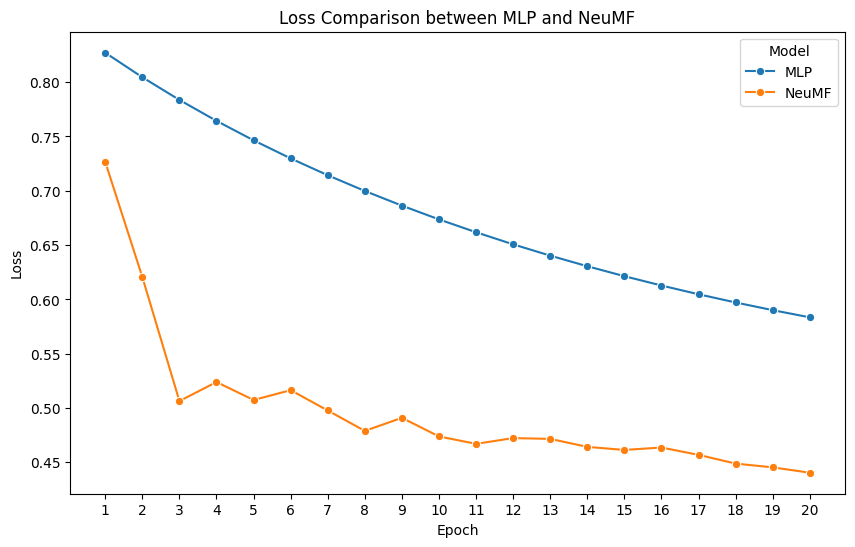

In [8]:
# Load data from the JSON files
with open('metrics_mlp.json', 'r') as f1:
    data1 = json.load(f1)
    losses1 = data1['losses_mlp']

with open('metrics_neumf.json', 'r') as f2:
    data2 = json.load(f2)
    losses2 = data2['losses']


df1 = pd.DataFrame({'epoch': range(1, len(losses1)+1), 'loss': losses1, 'model': 'MLP'})
df2 = pd.DataFrame({'epoch': range(1, len(losses2)+1), 'loss': losses2, 'model': 'NeuMF'})
df = pd.concat([df1, df2])

# Plot the loss curves
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='loss', hue='model', data=df, marker='o')
plt.title('Loss Comparison between MLP and NeuMF')  
plt.xlabel('Epoch')
plt.xticks(ticks=range(1, 21))
plt.ylabel('Loss')
plt.legend(title='Model') 
plt.show() 

It is important to note that even if the training loss is still decreasing, we stop at 20 epochs, because the recommendation metrics start decreasing too which means that the models are overfitting. Generally, the recommendation metrics reach their maximum around the 10th epoch as in the literature. So since these models are very costly computationally we choose to stop at 20 epochs.

### Effect of the number of recommendations

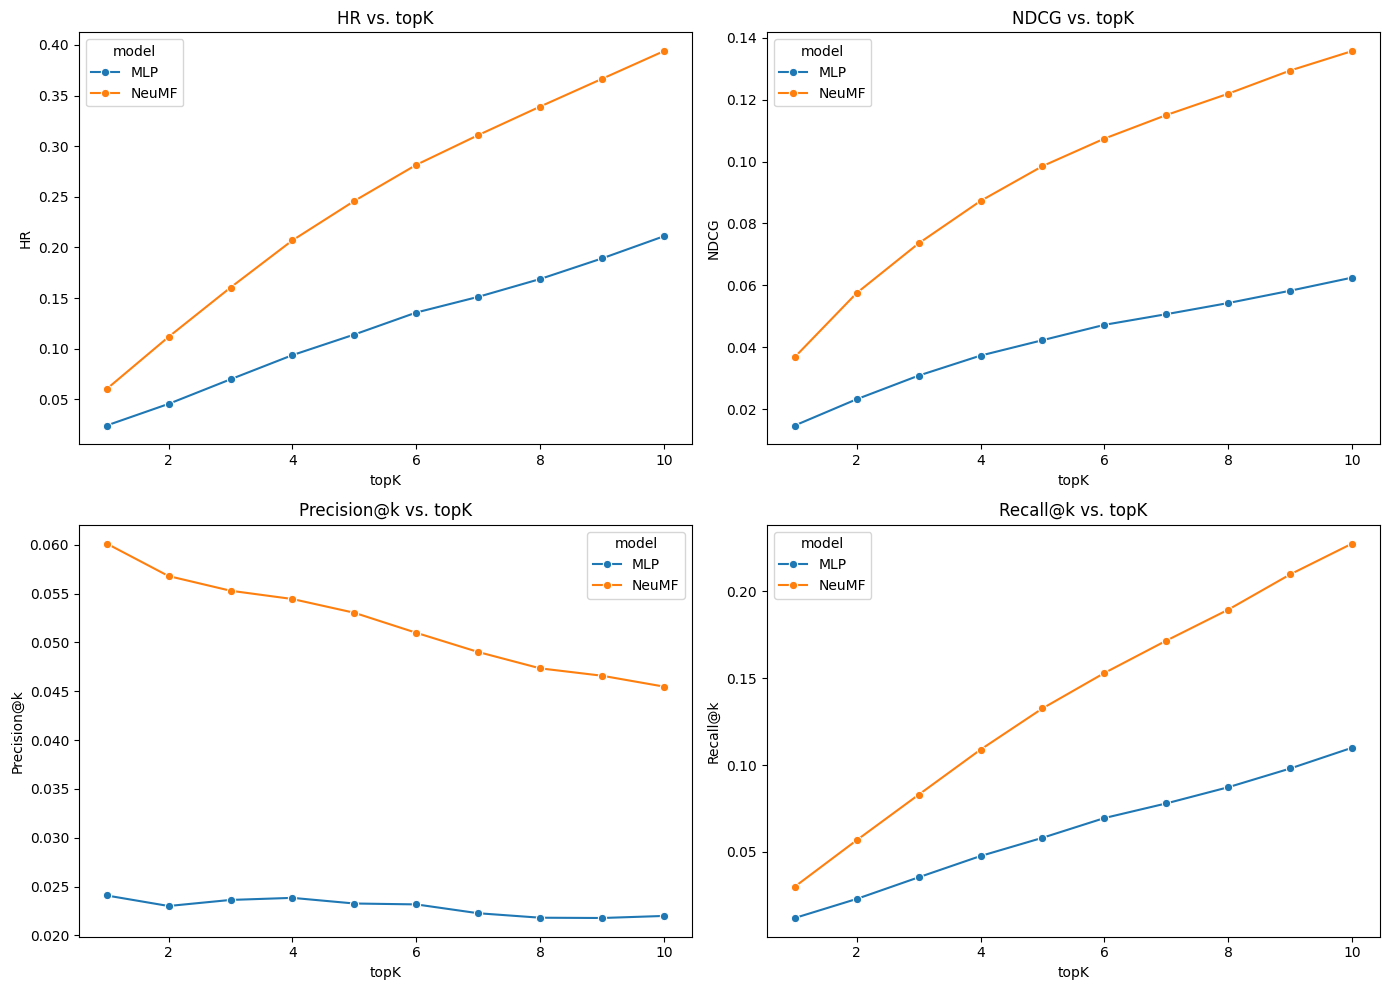

In [7]:
with open('metrics_mlp.json', 'r') as f1:
    data_model1 = json.load(f1)

with open('metrics_neumf.json', 'r') as f2:
    data_model2 = json.load(f2)

topK_values = list(range(1, 11))

# Metrics of MLP
best_hr_mlp = data_model1['best_hr_mlp']
best_ndcg_mlp = data_model1['best_ndcg_mlp']
best_p_mlp = data_model1['best_p_mlp']
best_r_mlp = data_model1['best_r_mlp']

# Metrics of neumf
best_hr_model2 = data_model2['best_hr']
best_ndcg_model2 = data_model2['best_ndcg']
best_p_model2 = data_model2['best_p']
best_r_model2 = data_model2['best_r']

df_hr_model1 = pd.DataFrame({'topK': topK_values, 'HR': best_hr_mlp, 'model': 'MLP'})
df_ndcg_model1 = pd.DataFrame({'topK': topK_values, 'NDCG': best_ndcg_mlp, 'model': 'MLP'})
df_p_model1 = pd.DataFrame({'topK': topK_values, 'Precision@k': best_p_mlp, 'model': 'MLP'})
df_r_model1 = pd.DataFrame({'topK': topK_values, 'Recall@k': best_r_mlp, 'model': 'MLP'})

df_hr_model2 = pd.DataFrame({'topK': topK_values, 'HR': best_hr_model2, 'model': 'NeuMF'})
df_ndcg_model2 = pd.DataFrame({'topK': topK_values, 'NDCG': best_ndcg_model2, 'model': 'NeuMF'})
df_p_model2 = pd.DataFrame({'topK': topK_values, 'Precision@k': best_p_model2, 'model': 'NeuMF'})
df_r_model2 = pd.DataFrame({'topK': topK_values, 'Recall@k': best_r_model2, 'model': 'NeuMF'})

df_combined_hr = pd.concat([df_hr_model1, df_hr_model2])
df_combined_ndcg = pd.concat([df_ndcg_model1, df_ndcg_model2])
df_combined_p = pd.concat([df_p_model1, df_p_model2])
df_combined_r = pd.concat([df_r_model1, df_r_model2])

# Plot the metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot HR
sns.lineplot(x='topK', y='HR', hue='model', data=df_combined_hr, ax=axes[0, 0], marker='o')
axes[0, 0].set_title('HR vs. topK')
axes[0, 0].set_xlabel('topK')
axes[0, 0].set_ylabel('HR')

# Plot NDCG
sns.lineplot(x='topK', y='NDCG', hue='model', data=df_combined_ndcg, ax=axes[0, 1], marker='o')
axes[0, 1].set_title('NDCG vs. topK')
axes[0, 1].set_xlabel('topK')
axes[0, 1].set_ylabel('NDCG')

# Plot Precision@k
sns.lineplot(x='topK', y='Precision@k', hue='model', data=df_combined_p, ax=axes[1, 0], marker='o')
axes[1, 0].set_title('Precision@k vs. topK')
axes[1, 0].set_xlabel('topK')
axes[1, 0].set_ylabel('Precision@k')

# Plot Recall@k
sns.lineplot(x='topK', y='Recall@k', hue='model', data=df_combined_r, ax=axes[1, 1], marker='o')
axes[1, 1].set_title('Recall@k vs. topK')
axes[1, 1].set_xlabel('topK')
axes[1, 1].set_ylabel('Recall@k')

# Adjust layout
plt.tight_layout()
plt.show()
